# Handling big data.
## Introduction:
This notebook is an implementation of pyspark and Spark MLib(Machine Learning library), the following are some interpretations on how to handle massive data and one way to visualize the behaviour of this data. Needless to say, k-means is an unsupervised machine learning algorithm that works well in most cases. 

# *1. Clustering with k-means.*

In [1]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 20.1 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.2-py2.py3-none-any.whl size=281824028 sha256=a47dbbf57b0d7ca928364c6ae5b0abe1fa5b78c78836fdab1479906b26f26176
  Stored in directory: /root/.cache/pip/wheels/6c/e3/9b/0525ce8a69478916513509d43693511463c6468db0de237c86
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7


In [2]:
from pyspark import SparkConf, SparkContext
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from scipy.spatial.distance import euclidean, cityblock
import seaborn as sns
sns.set_theme()
sns.set_palette('pastel')

In [3]:
from pyspark import SparkConf, SparkContext
import numpy as np

def kmeans(centroids, datos, itMax, dist):
    # Create a Spark configuration
    configuracion = SparkConf().setMaster("local").setAppName("kmeans")
    
    # Create a Spark context
    sc = SparkContext.getOrCreate(conf=configuracion)

    # Load the data and parse it into arrays of floats
    datos = sc.textFile(datos).map(lambda line: np.array([float(x) for x in line.split(' ')])).cache()

    # Load the initial centroids and parse them into arrays of floats
    centroids = sc.textFile(centroids).map(lambda line: np.array([float(x) for x in line.split(' ')])).collect()

    # Initialize a list to store the intra-cluster cost for each iteration
    cost = []

    # Run the k-means algorithm for the specified number of iterations
    for i in range(itMax):
        # Save a copy of the current centroids for comparison
        centroidsAux = centroids

        # Assign each point to its closest centroid and add the centroid index as a label
        labels = datos.map(lambda x: (np.argmin([dist(x, c) for c in centroids]), x))

        # Compute the new centroids by averaging the points in each cluster
        centroids = labels.groupByKey().map(lambda x: (x[0], np.mean(list(x[1]), axis=0))).sortByKey().map(lambda x: x[1]).collect()

        # Compute the intra-cluster cost and add it to the list
        if dist == euclidean:
            cost.append(sum(labels.groupByKey().map(lambda x: np.sum(
          np.linalg.norm(list(x[1]) - centroids[x[0]], axis=1)**2)).collect()))
        elif dist == cityblock:
            cost.append(sum(labels.groupByKey().map(lambda x: np.sum(np.sum(np.abs(list(x[1]) - centroids[x[0]]), axis=1))).collect()))

        # Check if the centroids have converged and exit the loop if they have
        if np.array_equal(centroids, centroidsAux):
            break

    # Return the cluster labels, final centroids, and intra-cluster costs
    return labels.map(lambda x: x[0]), centroids, cost


We will obtain the 

In [4]:
it = 30 #Number of iterations
data = "/content/data.txt"
centroids1 = "/content/c1.txt"
centroids2 = "/content/c2.txt"
##Comparison, first, we will focus mainly in the first centroids.
labelsCBlock, centroidsCBlock, costCBlock = kmeans(centroids1, data,it,cityblock )
labelsEuclidean, centroidsEuclidean, costEuclidean = kmeans(centroids1, data,it,euclidean )

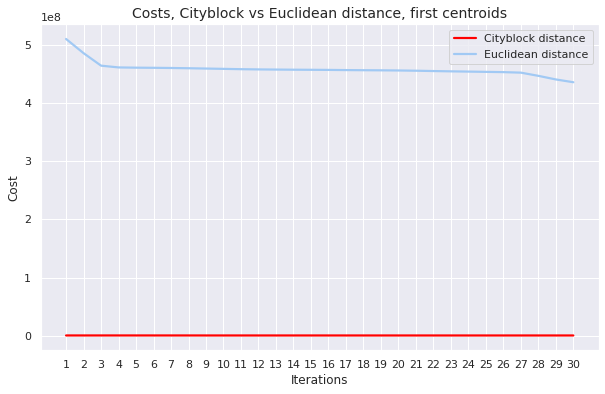

In [5]:
x = np.linspace(1, 30,30)
plt.figure(figsize=(10,6))
plt.title("Costs, Cityblock vs Euclidean distance, first centroids", size=14)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.plot(x,costCBlock , label='Cityblock distance', linewidth=2.2,color='red')
plt.plot(x,costEuclidean , label='Euclidean distance', linewidth=2.2)
plt.legend()
plt.xticks(x);

b)

Same comparison, but using the second centroids.

In [6]:
labelsCBlock, centroidsCBlock, costCBlock = kmeans(centroids2, data,it,cityblock)
labelsEuclidean, centroidsEuclidean, costEuclidean = kmeans(centroids2, data,it,euclidean )

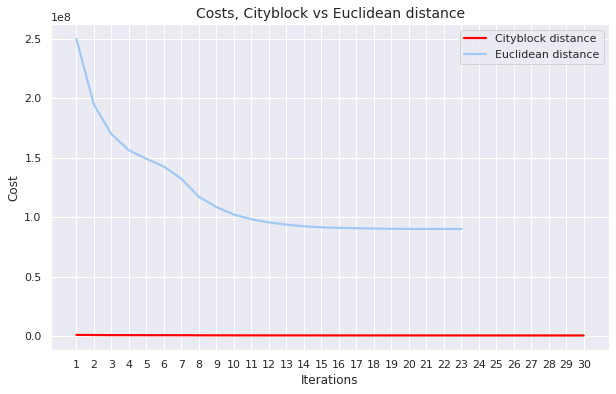

In [7]:
x = np.linspace(1, 30,30)
y = np.linspace(1, 23,23)
plt.figure(figsize=(10,6))
plt.title("Costs, Cityblock vs Euclidean distance", size=14)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.plot(x,costCBlock , label='Cityblock distance', linewidth=2.2,color='red')
plt.plot(y,costEuclidean , label='Euclidean distance', linewidth=2.2)
plt.legend()
plt.xticks(x);

c) 

Let us tSNE to visualize our clustering, just to remember, tSNE is a visaluazation tecnique that reduces the dimensions of data.

In [8]:
config = SparkConf().setMaster("local").setAppName("kmeans")
sc = SparkContext.getOrCreate(conf=config)
data = sc.textFile(data).map(lambda line: np.array([float(x) for x in line.split(' ')])).cache()
tsne = TSNE(n_components=2, random_state=42)
dataReduced = np.array(data.collect())
datos2D = tsne.fit_transform(dataReduced)

Graphing with their respective labels:

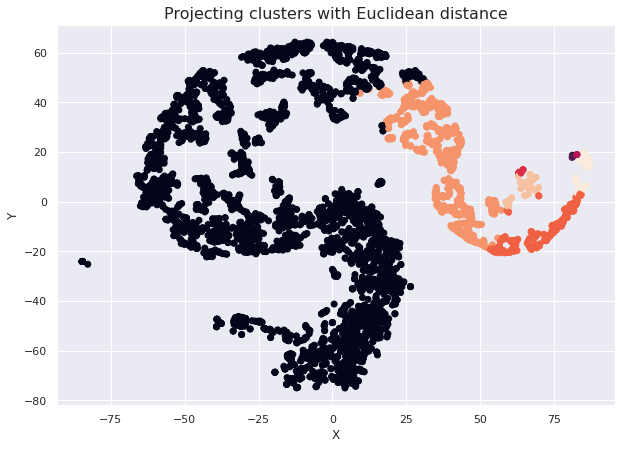

In [9]:
plt.figure(figsize=(10,7))
plt.title('Projecting clusters with Euclidean distance', size=16)
plt.xlabel('X')
plt.ylabel('Y')
plt.scatter(datos2D[:, 0], datos2D[:, 1], c=labelsCBlock.collect())

## Insights

It is not entirely easy to give an interpretation of these results. We see that for the initial centers chosen randomly (centers 1), it seems that better distributed groups are generated with less variability in their number of elements. However, since we have reduced a 50-dimensional space to just two dimensions, we cannot rush to conclude that one clustering is better than the other. The intra-cluster cost for the initial centers chosen with k-means++ (centers 2) is lower than the cost generated by the other centers, which may indicate that, despite the projection not appearing to have produced a good clustering, in the 50-dimensional space, the initial centers chosen with k-means++ reduced the intra-cluster cost better. 

## Time and space complexity.

The time complexity of the k-means algorithm is $O(I ⋅ k ⋅ n ⋅ d)$, where I is the number of iterations, k is the number of clusters, n is the number of data points, and d is the number of dimensions in the data.

The k-means algorithm is an iterative algorithm, meaning that it repeats a set of steps until some convergence criterion is met. In each iteration, the algorithm first assigns each data point to the nearest centroid, then updates the centroids by computing the mean of the points assigned to each cluster.

The time complexity of the algorithm depends on the number of iterations required for convergence. In practice, the algorithm often converges after a small number of iterations, typically between 10 and 100. However, in worst-case scenarios, the algorithm may take many iterations to converge, which can make the time complexity prohibitively expensive for very large datasets.

To mitigate the time complexity of k-means for large datasets, various improvements have been proposed, such as using parallel processing, sampling techniques, and approximate nearest neighbor methods. These techniques can significantly reduce the time required to converge to a solution.

The space complexity of the k-means algorithm is $O(k ⋅ n ⋅ d)$, where k is the number of clusters, n is the number of data points, and d is the number of dimensions in the data.

The k-means algorithm requires storing the centroids of each cluster, which is $O(k ⋅ d)$ space. Additionally, the algorithm needs to store the data points themselves, which is $O(n ⋅ d)$ space. During the algorithm, the data points are typically stored in memory, which can be a limiting factor for very large datasets.

In addition to storing the data and centroids, the algorithm may also require temporary storage for intermediate calculations, such as the distance between data points and centroids. The amount of temporary storage required depends on the specific implementation of the algorithm.

Overall, the space complexity of k-means is generally less of a concern than the time complexity, since the amount of memory required for most datasets is manageable on modern computer systems. However, for very large datasets, it may be necessary to use specialized techniques such as distributed computing or online algorithms to reduce the memory requirements of the algorithm.

# 2.Logistic Regression and classification

### Introduction to MLpipelines and feature transformers.

ML pipelines and feature transformers are both important concepts in machine learning, particularly in the context of building and training models.

ML pipelines refer to a series of steps that are taken in order to train and deploy a machine learning model. These steps typically include data pre-processing, feature extraction, model training, and model evaluation. The goal of an ML pipeline is to automate the process of building and deploying machine learning models, making it easier for developers to create and deploy models quickly and efficiently.

Feature transformers are a specific type of component within an ML pipeline that is responsible for pre-processing the input data in order to extract and transform the relevant features for model training. Feature transformers can take a variety of different forms, depending on the nature of the data being analyzed and the specific requirements of the model being trained.

Some common examples of feature transformers include one-hot encoding, which is used to convert categorical data into a numerical format, and normalization, which is used to ensure that all features have similar ranges and distributions. Other feature transformers might be designed to perform more complex transformations, such as extracting text features from natural language data or applying image filters to image data.

Overall, ML pipelines and feature transformers are both essential components in the machine learning process, and are used to automate and streamline the process of model building and deployment, making it easier for developers to create and train models that can be deployed in real-world applications.

In [10]:
from pyspark.ml.classification import LogisticRegression

In [11]:
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler


spark = SparkSession.builder.appName("categorical-to-numerical").getOrCreate()



df = spark.read.csv("/content/adultUCI.csv", header=False, inferSchema=True)


df = df.toDF("Age"
,"Workclass"
,"Final weight"
,"Education"
,"Education number"
,"Marital status"
,"Occupation"
,"Relationship"
,"Race"
,"Sex"
,"Capital gain"
,"Capital loss"
,"Hours per week"
,"Native country"
,"Income")

df.show(15)

+---+-----------------+------------+-------------+----------------+--------------------+------------------+--------------+-------------------+-------+------------+------------+--------------+--------------+------+
|Age|        Workclass|Final weight|    Education|Education number|      Marital status|        Occupation|  Relationship|               Race|    Sex|Capital gain|Capital loss|Hours per week|Native country|Income|
+---+-----------------+------------+-------------+----------------+--------------------+------------------+--------------+-------------------+-------+------------+------------+--------------+--------------+------+
| 39|        State-gov|     77516.0|    Bachelors|            13.0|       Never-married|      Adm-clerical| Not-in-family|              White|   Male|      2174.0|         0.0|          40.0| United-States| <=50K|
| 50| Self-emp-not-inc|     83311.0|    Bachelors|            13.0|  Married-civ-spouse|   Exec-managerial|       Husband|              White|  

In [12]:
df.columns

['Age',
 'Workclass',
 'Final weight',
 'Education',
 'Education number',
 'Marital status',
 'Occupation',
 'Relationship',
 'Race',
 'Sex',
 'Capital gain',
 'Capital loss',
 'Hours per week',
 'Native country',
 'Income']

In [13]:
# Specify the list of categorical columns
categorical =['Workclass','Marital status','Relationship','Race','Education','Sex','Occupation', 'Native country']

# Create StringIndexer objects to convert the categorical columns to numerical indices
indexers = [StringIndexer(inputCol=col, outputCol=col+"Index") for col in categorical]

# Create OneHotEncoder objects to convert the numerical indices to binary vectors
encoders = [OneHotEncoder(inputCol=col+"Index", outputCol=col+"Vec") for col in categorical]

# Combine the binary vectors into a single feature vector using VectorAssembler
assembler = VectorAssembler(inputCols=[col+"Vec" for col in categorical], outputCol="features")

# Define a pipeline of stages that includes the indexers, encoders, and assembler
pipeline = Pipeline(stages=indexers + encoders + [assembler])

# Fit the pipeline to the DataFrame and transform the DataFrame
df = pipeline.fit(df).transform(df)


In [14]:
df.columns

['Age',
 'Workclass',
 'Final weight',
 'Education',
 'Education number',
 'Marital status',
 'Occupation',
 'Relationship',
 'Race',
 'Sex',
 'Capital gain',
 'Capital loss',
 'Hours per week',
 'Native country',
 'Income',
 'WorkclassIndex',
 'Marital statusIndex',
 'RelationshipIndex',
 'RaceIndex',
 'EducationIndex',
 'SexIndex',
 'OccupationIndex',
 'Native countryIndex',
 'WorkclassVec',
 'Marital statusVec',
 'RelationshipVec',
 'RaceVec',
 'EducationVec',
 'SexVec',
 'OccupationVec',
 'Native countryVec',
 'features']

In [15]:
df = df.drop(*['Workclass','Marital status','Relationship','Race','Education','Sex','Occupation', 'Native country','WorkclassIndex',
 'Marital statusIndex',
 'RelationshipIndex',
 'RaceIndex',
 'EducationIndex',
 'SexIndex',
 'OccupationIndex',
 'Native countryIndex',
 'WorkclassVec',
 'Marital statusVec',
 'RelationshipVec',
 'RaceVec',
 'EducationVec',
 'SexVec',
 'OccupationVec',
 'Native countryVec'])

In [16]:
df.columns

['Age',
 'Final weight',
 'Education number',
 'Capital gain',
 'Capital loss',
 'Hours per week',
 'Income',
 'features']

In [17]:
# Define a list of column names that contains a single element, "Income"
columnasCat = ['Income']

# Create a list of StringIndexer objects, which are used to transform categorical columns into numeric indices
# Loop over the columnasCat list and generate a new StringIndexer for each column using a list comprehension
stringIndexers = [StringIndexer(inputCol=col, outputCol=col+"Index") for col in columnasCat]

# Create a Pipeline object that contains the list of StringIndexer objects
pipeline = Pipeline(stages=stringIndexers)

# Fit the pipeline to the DataFrame df using the fit method
pipeline = pipeline.fit(df)

# Transform the DataFrame df using the fitted pipeline with the transform method
df = pipeline.transform(df)

# Drop the original categorical column "Income" from the transformed DataFrame using the drop method
df = df.drop(*columnasCat)

# Display the first 5 rows of the transformed DataFrame using the show method
df.show(5)


+---+------------+----------------+------------+------------+--------------+--------------------+-----------+
|Age|Final weight|Education number|Capital gain|Capital loss|Hours per week|            features|IncomeIndex|
+---+------------+----------------+------------+------------+--------------+--------------------+-----------+
| 39|     77516.0|            13.0|      2174.0|         0.0|          40.0|(94,[4,9,15,19,25...|        0.0|
| 50|     83311.0|            13.0|         0.0|         0.0|          13.0|(94,[1,8,14,19,25...|        0.0|
| 38|    215646.0|             9.0|         0.0|         0.0|          40.0|(94,[0,10,15,19,2...|        0.0|
| 53|    234721.0|             7.0|         0.0|         0.0|          40.0|(94,[0,8,14,20,28...|        0.0|
| 28|    338409.0|            13.0|         0.0|         0.0|          40.0|(94,[0,8,18,20,25...|        0.0|
+---+------------+----------------+------------+------------+--------------+--------------------+-----------+
only showi

In [18]:
# Split the DataFrame df into training and testing sets using a 70/30 split and a fixed seed for reproducibility
dfTrain, dfTest = df.randomSplit([0.7, 0.3], seed=100)

# Define a VectorAssembler object that combines several input columns into a single output column called "sparseColumn"
assembler = VectorAssembler(
    inputCols=['Age',
               'Final weight',
               'Education number',
               'Capital gain',
               'Capital loss',
               'Hours per week',
               'features', 
               'IncomeIndex'],
    outputCol="sparseColumn"
)

# Apply the VectorAssembler transformation to the training set dfTrain to create a new DataFrame assembledDfTrain
assembledDfTrain = assembler.transform(dfTrain)

# Define a LogisticRegression object with the training set's "sparseColumn" as the features and "IncomeIndex" as the label, and set the maximum number of iterations to 10
lr = LogisticRegression(featuresCol='sparseColumn', labelCol='IncomeIndex', maxIter=10)

# Train the LogisticRegression model using the assembledDfTrain DataFrame
model = lr.fit(assembledDfTrain)

# Apply the trained model to the assembledDfTrain DataFrame to generate predictions, then select the "IncomeIndex" and "probability" columns, and map the RDD to a tuple of (probability, income index) for each row
predictions = model.transform(assembledDfTrain).select('IncomeIndex', 'probability').rdd.map(lambda x: (float(x['probability'][1]), float(x['IncomeIndex'])))

# Display the first 5 rows of the predictions RDD
predictions.take(5)


[(9.631568022694381e-05, 0.0),
 (0.0001599440457821233, 0.0),
 (0.00010447750297293279, 0.0),
 (9.670419057905555e-05, 0.0),
 (0.00010418090123653911, 0.0)]

Now, let's evaluate our results and model with the ROC method. 

Text(0.5, 1.0, 'ROC Curve')

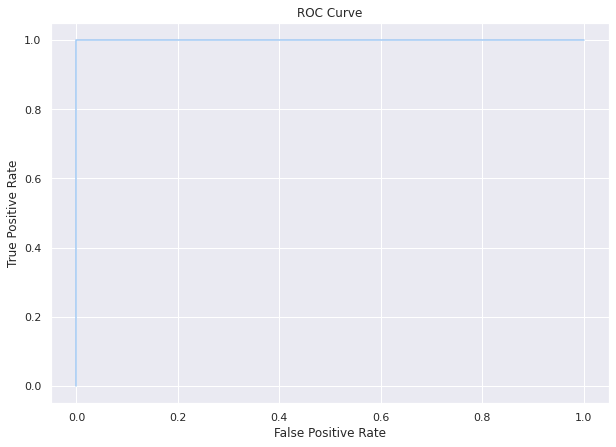

In [20]:
# Import the necessary libraries for generating ROC and precision-recall curves
from sklearn.metrics import roc_curve, precision_recall_curve

# Use the predictions RDD to generate the false positive rate (fpr), true positive rate (tpr), and corresponding thresholds for the ROC curve
fpr, tpr, thresholds = roc_curve([x[1] for x in predictions.collect()], [x[0] for x in predictions.collect()])

# Set the size of the figure to 10x7 inches
plt.figure(figsize=(10, 7))

# Plot the ROC curve using the fpr as the x-axis and tpr as the y-axis
plt.plot(fpr, tpr)

# Label the x-axis as "False Positive Rate"
plt.xlabel('False Positive Rate')

# Label the y-axis as "True Positive Rate"
plt.ylabel('True Positive Rate')

# Set the title of the plot as "ROC Curve"
plt.title('ROC Curve')

An L-shaped ROC curve indicates that the performance of the binary classification model is poor. Specifically, it suggests that the model is unable to distinguish between the positive and negative classes, and its true positive rate (sensitivity) is not improving as the false positive rate (1-specificity) is decreasing.

There are several potential reasons why the model's performance may be poor. For example, the features used to train the model may not be informative enough to distinguish between the classes. Alternatively, the model may be overfitting to the training data, resulting in poor generalization to new, unseen data. Another possibility is that the class distribution in the dataset is heavily imbalanced, which can make it difficult for the model to learn to distinguish between the positive and negative classes.

In order to improve the model's performance, several approaches could be tried. One approach is to collect more informative features or to engineer new features that better capture the underlying patterns in the data. Another approach is to try different algorithms or models that may be better suited to the problem. Additionally, techniques such as regularization, cross-validation, and data augmentation may be used to prevent overfitting and improve generalization.

Ultimately, the L-shaped ROC curve is a clear signal that the model is not performing well, and further investigation and experimentation is needed to identify the specific factors contributing to poor performance and to develop strategies for improvement.